In [1]:
import sys
import os
import numpy as np
import MDAnalysis as mda
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
cur_path1 = os.getcwd()
print(cur_path1)

C:\Users\pcuser\Desktop\tutorial\AFP\lp\bias\8A\qbar6


In [3]:
q_star_arr = [ "100", "200", "300", "400", "500", "600", "700", "800", "900", "1000", "1100", "1200", "1300", "1400", "1500" ]

In [4]:
#Get atom_pos for each universe for each time frame (N, timeframe, positions(M molecules,3))
atom_pos = []
u_list = []
index_file = "solid_like_atoms.index"


for i in q_star_arr:
    work_path = cur_path1 + "\\" +i
    os.chdir(work_path)
    u = mda.Universe("bias.gro","bias_whole.xtc")
    u_list += [u]
    
    solid_ndx = []
    df = open(index_file, "r+")
    for line in df.readlines():
        solid = np.fromstring(line, dtype=int, sep=' ') -1
        solid_ndx += [solid]
        
    print('there are %s time frames in %s q_star' %(len(solid_ndx), i))
    
    solid_pos = []
    for j in range(len(solid_ndx)):
        solid = solid_ndx[j]
        solid_poss = np.zeros([len(solid), 3])
        for k in range(len(solid)):
            solid_poss[k] = u.atoms[solid[k]].position
        solid_pos += [solid_poss]

    
    atom_pos += [solid_pos]
    
atom_pos = atom_pos[:-1]
ref_pos = atom_pos[-1]

there are 101 time frames in 100 q_star
there are 101 time frames in 200 q_star
there are 101 time frames in 300 q_star
there are 101 time frames in 400 q_star
there are 101 time frames in 500 q_star
there are 101 time frames in 600 q_star
there are 101 time frames in 700 q_star
there are 101 time frames in 800 q_star
there are 101 time frames in 900 q_star
there are 101 time frames in 1000 q_star
there are 101 time frames in 1100 q_star
there are 101 time frames in 1200 q_star
there are 101 time frames in 1300 q_star
there are 101 time frames in 1400 q_star
there are 101 time frames in 1500 q_star


In [5]:
#get surface atom's position
# surface_pos is the key

u = u_list[-1]
ref_indx = "surface.ndx"

sf = open(ref_indx, "r+")
surface_ndx = []
for line in sf.readlines():
    surface_ndx += [np.int(line)]
surface_ndx = np.array(surface_ndx)

#convert to python scheme
surface_ndx = surface_ndx - 1

surface_pos = np.zeros([len(surface_ndx), 3])
for i in range(len(surface_ndx)):
    surface_pos[i] = u.atoms[surface_ndx[i]].position
print('there are %s surface atoms in this simulation.' % surface_pos.shape[0])

there are 241 surface atoms in this simulation.


In [6]:
# This code is written by Jeongmoon Choi
# email: jeongmoon2006@gmail.com

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

class density_near_surface:
    '''
    Calculates density near surface and returns heavy atoms that satisfies density > cutoff
    
    Args:
    atom_pos(list): atom position of interest per simulation, time (# of simulation, # time frame, (# of atom, 3))
    ref_pos(list): reference atom position of interest for one simulation. (# time frame, (# of atom, 3))
    surface_pos(numpy.ndarray): surface atom position (# of surface atoms, 3)
    box(numpy.ndarray): simuation box size (3,)
    radius_cutoff(float): cutoff for union of sphere's radius
    density_cutoff(float): cutoff for density
    
    Density counts number of ice molecules surrounded by a sphere centering i'th heavy atom's position and radius as radius_cutoff  

    '''
    
    def __init__(self, atom_pos, ref_pos, surface_pos, box, surface_index, radius_cutoff, density_cutoff=0.5):
        self.atom_pos = atom_pos
        self.ref_pos = ref_pos
        self.surface_pos = surface_pos
        self.box = box
        self.radius_cutoff = radius_cutoff
        self.density_cutoff = density_cutoff
        self.surface_index = surface_index
        
        #for reference
        self.ref_solid_count = np.zeros((len(self.surface_pos), len(self.ref_pos))) # (# of surface atom, # of data frame)
        self.avg_ref_solid_count = np.zeros(len(self.surface_pos),)
        
        #for real
        self.solid_count = [] # (# of data frame, # of surface atoms, # of simulations)
        self.avg_solid_count = []  #( # of surface atoms, # of simulations)
        
        #if i th surface atom;s density is greater than cutoff, it is 1, if not 0
        self.true_density = [] #(# of simulations, # of surface atoms)
        # index of surface atom where density is greater than cutoff
        self.surface_density_ndx = [] #(# of simulations, # of surface atoms)
        
        
    def get_ref_density(self):
        # i for time frame
        for i in range(len(self.ref_pos)):
            ref_poss = self.ref_pos[i]
            dist = np.abs(ref_poss[:, np.newaxis, :] - self.surface_pos)
            cond = 1*(dist > self.box/2)
            dist = abs(cond*self.box - dist)
            dist = np.sum(dist*dist, axis = 2).T
            dist = np.sqrt(dist)
            
            self.ref_solid_count[:,i] = np.count_nonzero( dist < self.radius_cutoff , axis = 1)

        self.avg_ref_solid_count = np.average(self.ref_solid_count, axis = 1)
        
        return self.avg_ref_solid_count
    
    def get_density(self):
        # i for simulation
        for i in range(len(self.atom_pos)):
            solid_countt = np.zeros((len(self.surface_pos), len(self.ref_pos)))
            t_atom_position = self.atom_pos[i]
            
            #j for time frame
            for j in range(len(t_atom_position)):
                atom_poss = t_atom_position[j]
                dist = np.abs(atom_poss[:, np.newaxis, :] - self.surface_pos)
                cond = 1*(dist > self.box/2)
                dist = abs(cond*self.box - dist)
                dist = np.sum(dist*dist, axis = 2).T
                dist = np.sqrt(dist)
                
                solid_countt[:,j] = np.count_nonzero( dist < self.radius_cutoff, axis = 1)
            self.avg_solid_count += [np.average(solid_countt, axis = 1)]
        
        
        return self.avg_solid_count
    
    def compare_density(self):
        # i for simulation
        for i in range(len(self.atom_pos)):
            density = self.avg_solid_count[i]/self.avg_ref_solid_count
            true_density = density > self.density_cutoff
            true_density = true_density.astype(int)
            surface_index = true_density*self.surface_index
            surface_index = surface_index[np.nonzero(surface_index)]
            
            self.true_density += [true_density]
            self.surface_density_ndx += [surface_index]
        
        return self.true_density, self.surface_density_ndx

In [7]:
dnf = density_near_surface(atom_pos, ref_pos, surface_pos, np.array([61.3804, 78.2105, 57.4204]), surface_ndx, 8, 0.5)

In [8]:
avg_ref_solid_count = dnf.get_ref_density()

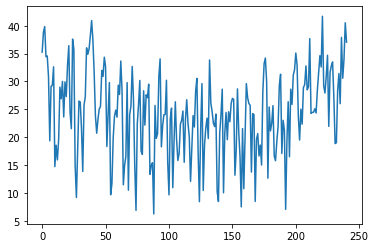

In [9]:
plt.plot(avg_ref_solid_count)

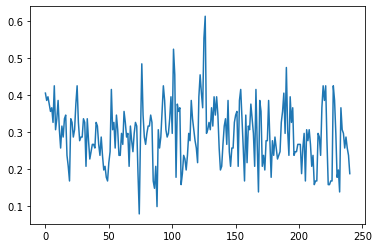

In [10]:
avg_solid_count = dnf.get_density()
plt.plot(avg_solid_count[0])

14


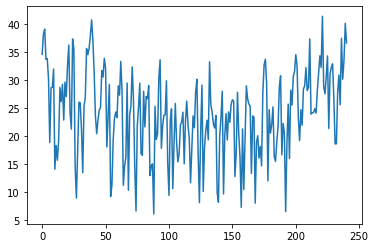

In [11]:
print(len(avg_solid_count))
plt.plot(avg_ref_solid_count - avg_solid_count[1])

In [12]:
true_density, true_surface_index = dnf.compare_density()

In [14]:

#Save file

p = 0
for i in q_star_arr[:-1]:
    work_path = cur_path1 + "\\" +i
    os.chdir(work_path)
    tsi = true_surface_index[p]
    p += 1
    
    print(p)
    
    if len(tsi) == 0:
        continue
    else:
        np.savetxt('IPS_density_0.5.txt',tsi, fmt='%s')

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [13]:
true_surface_index

[array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([ 820, 1013, 1014, 1042, 1193, 1197, 1221]),
 array([ 286,  290,  299,  300,  387,  390,  475,  478,  490,  572,  575,
         578,  595,  670,  672,  684,  755,  758,  760,  764,  946,  954,
         960,  964, 1107, 1130, 1135, 1138, 1142, 1144, 1147, 1280, 1284,
        1303, 1308, 1311, 1315]),
 array([  85,   88,  101,  254,  278,  284,  286,  290,  299,  300,  313,
         314,  472,  475,  478,  490,  498,  501,  502,  503,  632,  655,
         660,  662,  666,  670,  672,  684,  696,  697,  820,  827,  848,
         853,  855,  859,  863,  871,  872,  883,  884,  897,  898,  954,
        1013, 1014, 1042, 1048, 1052, 1060, 1076, 1078, 1130, 1135, 1138,
        1142, 1144, 1147, 1193, 1197, 1221, 1224, 1228, 1230, 1303, 1308,
        1311, 1315, 1370, 1400, 1403]),
 array([  36,   40,   43,   67,   70,  210,  224,  245,  249,  254,  273,
         278,  284,  286,  299,  3